# MIRACA CBA Model

In this example, we develop a stylised example template for Cost-benefit Analysis (CBA)

CBA involves prior estimation of the Expected Annnual direct Damages (EAD) and Expected Annual indirect Economic Losses (EAEL) with and without the implementation of an adaptation option.
These losses are estimated over a set of consecutive years or in most cases at specific time horizons.
For example - EAD and EAEL might be estimated for a given baseline year (e.g. 2025) and for future years for which climate scenario-based hazard maps might be created (e.g. 2050, 2080 SSP3 7.0)

CBA also requires inputs of the initial investment costs of the adaptation option, and its maintenance costs (recurrent and periodic)

Further inputs include the timeline of the CBA assessment and discount rates
Economic GPD growth rates might also be needed to project future EAELs

## CBA outputs

Benefits = Avoided Damages and Losses over time = (EAD_withoutadaptaion - EAD_withadaptation) + (EAEL_withoutadaptation - EAEL_withadaptation)

Costs = Initial investment + Maintenance over time

Benefit-Cost Ratio (BCR) = (Discounted Benefits)/(Discounted Costs)


In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from cba.cba_functions import *

warnings.simplefilter("ignore")
base_path = Path(os.path.dirname(os.getcwd()) + "/data")
outpath = Path(os.path.dirname(os.getcwd()) + "/output")

### Read CBA model parameters


In [2]:
loss_id_column = "id"
dimension_column = "length"
loss_columns = ["EAD", "EAEL"]
cost_columns = ["initial_investment", "periodic_maintenance", "recurrent_maintenance"]
year_column = "year"
options_columns = ["option", "hazard"]

In [3]:
parameter_df = pd.read_csv(base_path / "cba_parameters.csv")
parameters = parameter_df.set_index("parameter").to_dict()["value"]
st_y = int(parameters["start_year"])
en_y = int(parameters["end_year"])
d_r = float(parameters["discount_rate"])
apply_gdp_series = parameters["apply_gdp_timeseries"]
apply_gdp_fixed_rate = parameters["apply_fixed_gdp_growth"]
gdp_r = float(parameters["gdp_rate"])

In [4]:
timeseries = np.arange(st_y, en_y + 1, 1)

### Read damages and losses without adaptation and convert to timeseries


In [5]:
noadapt_df = pd.read_csv(base_path / "without_adaptation_losses.csv")
noadapt_df = estimate_risk_time_series(
    noadapt_df, ["hazard"], loss_columns, "year", st_y, en_y
)

### Read damages and losses with adaptation and convert to timeseries


In [6]:
adapt_df = pd.read_csv(base_path / "with_adaptation_losses.csv")
adapt_df = estimate_risk_time_series(
    adapt_df, ["hazard", "option"], loss_columns, "year", st_y, en_y
)

### Merge the loss dataframes and estimate avoided losses


In [7]:
noadapt_df.rename(
    columns=dict([(lc, f"{lc}_noadapt") for lc in loss_columns]), inplace=True
)
adapt_df.rename(
    columns=dict([(lc, f"{lc}_adapt") for lc in loss_columns]), inplace=True
)
n_idx_cols = [c for c in noadapt_df.columns.values.tolist() if c not in loss_columns]
a_idx_cols = [c for c in adapt_df.columns.values.tolist() if c not in loss_columns]

adapt_df = pd.merge(
    adapt_df, noadapt_df, how="left", on=list(set(a_idx_cols).intersection(n_idx_cols))
)
for lc in loss_columns:
    adapt_df[f"avoided_{lc}"] = adapt_df[f"{lc}_noadapt"] - adapt_df[f"{lc}_adapt"]

### Project the Avoided Economic losses by some GDP change factor, if needed


In [8]:
gr_f = []
if apply_gdp_series == "TRUE":
    gr_f = pd.read_csv(base_path / "gdp_timeseries.csv")
    gr_f = list(gr_f.itertuples(index=False, name=None))
    gr_f = calculate_growth_rate_factor(gr_f, st_y, en_y)
elif apply_gdp_fixed_rate == "TRUE":
    gr_f = calculate_growth_rate_factor(gdp_r, st_y, en_y)

if len(gr_f) > 0:
    gr_f = pd.DataFrame(gr_f, columns=[year_column, "gdp_factor"])
    adapt_df = pd.merge(adapt_df, gr_f, how="left", on=[year_column])
    adapt_df["avoided_EAEL"] = adapt_df["avoided_EAEL"] * adapt_df["gdp_factor"]
    adapt_df.drop("gdp_factor", axis=1, inplace=True)

### Estimate the adaptation cost timeseries


In [9]:
cost_df = pd.read_csv(base_path / "adaptation_options_and_costs.csv")
cost_df = estimate_adaptation_cost_time_series(
    cost_df, ["option", "hazard", "adapt_cost_uom"], start_year=st_y, end_year=en_y
)

### Merge the adaptation losses with the adptation costs to estimates the benefits and cost


In [10]:
adapt_df = pd.merge(
    adapt_df, cost_df, how="left", on=options_columns + [year_column]
).fillna(0)
adapt_df["benefit"] = adapt_df[[f"avoided_{lc}" for lc in loss_columns]].sum(axis=1)
adapt_df["cost"] = adapt_df[cost_columns].sum(axis=1)
adapt_df["cost"] = adapt_df["cost"] * adapt_df[dimension_column]

### Do the discounting of the Benefits and the costs based on the discount rate


In [11]:
dis_series = calculate_discounting_rate_factor(
    discount_rate=d_r, start_year=st_y, end_year=en_y, maintain_period=1.0
)
dis_df = pd.DataFrame(
    list(zip(timeseries, dis_series)), columns=[year_column, "discount_rate"]
)
adapt_df = pd.merge(adapt_df, dis_df, how="left", on=[year_column])
adapt_df["benefit_pv"] = adapt_df["benefit"] * adapt_df["discount_rate"]
adapt_df["cost_pv"] = adapt_df["cost"] * adapt_df["discount_rate"]

### Estimate the added benefits, costs, and BCR summed over the timeseries


In [12]:
sum_columns = ["benefit", "cost", "benefit_pv", "cost_pv"]
df = (
    adapt_df.groupby([loss_id_column] + options_columns)
    .agg(dict([(c, "sum") for c in sum_columns]))
    .reset_index()
)
df["BCR"] = df["benefit_pv"] / df["cost_pv"]
df

,id,option,hazard,benefit,cost,benefit_pv,cost_pv,BCR
0,1,flood wall,flood,32627.951377,4875.0,9335.697257,2863.302085,3.260465
1,1,swales,flood,20718.844610,1625.0,5949.529544,954.434028,6.233568
2,2,flood wall,flood,2238.576048,975.0,660.842549,572.660417,1.153987
3,2,swales,flood,809.483236,325.0,254.502424,190.886806,1.333264


### Save the final results


In [13]:
df.to_csv(outpath / "CBA_result.csv", index=False)

### Test - Plot of Benefit and Cost timeseries with a without discounting


<Axes: xlabel='year'>

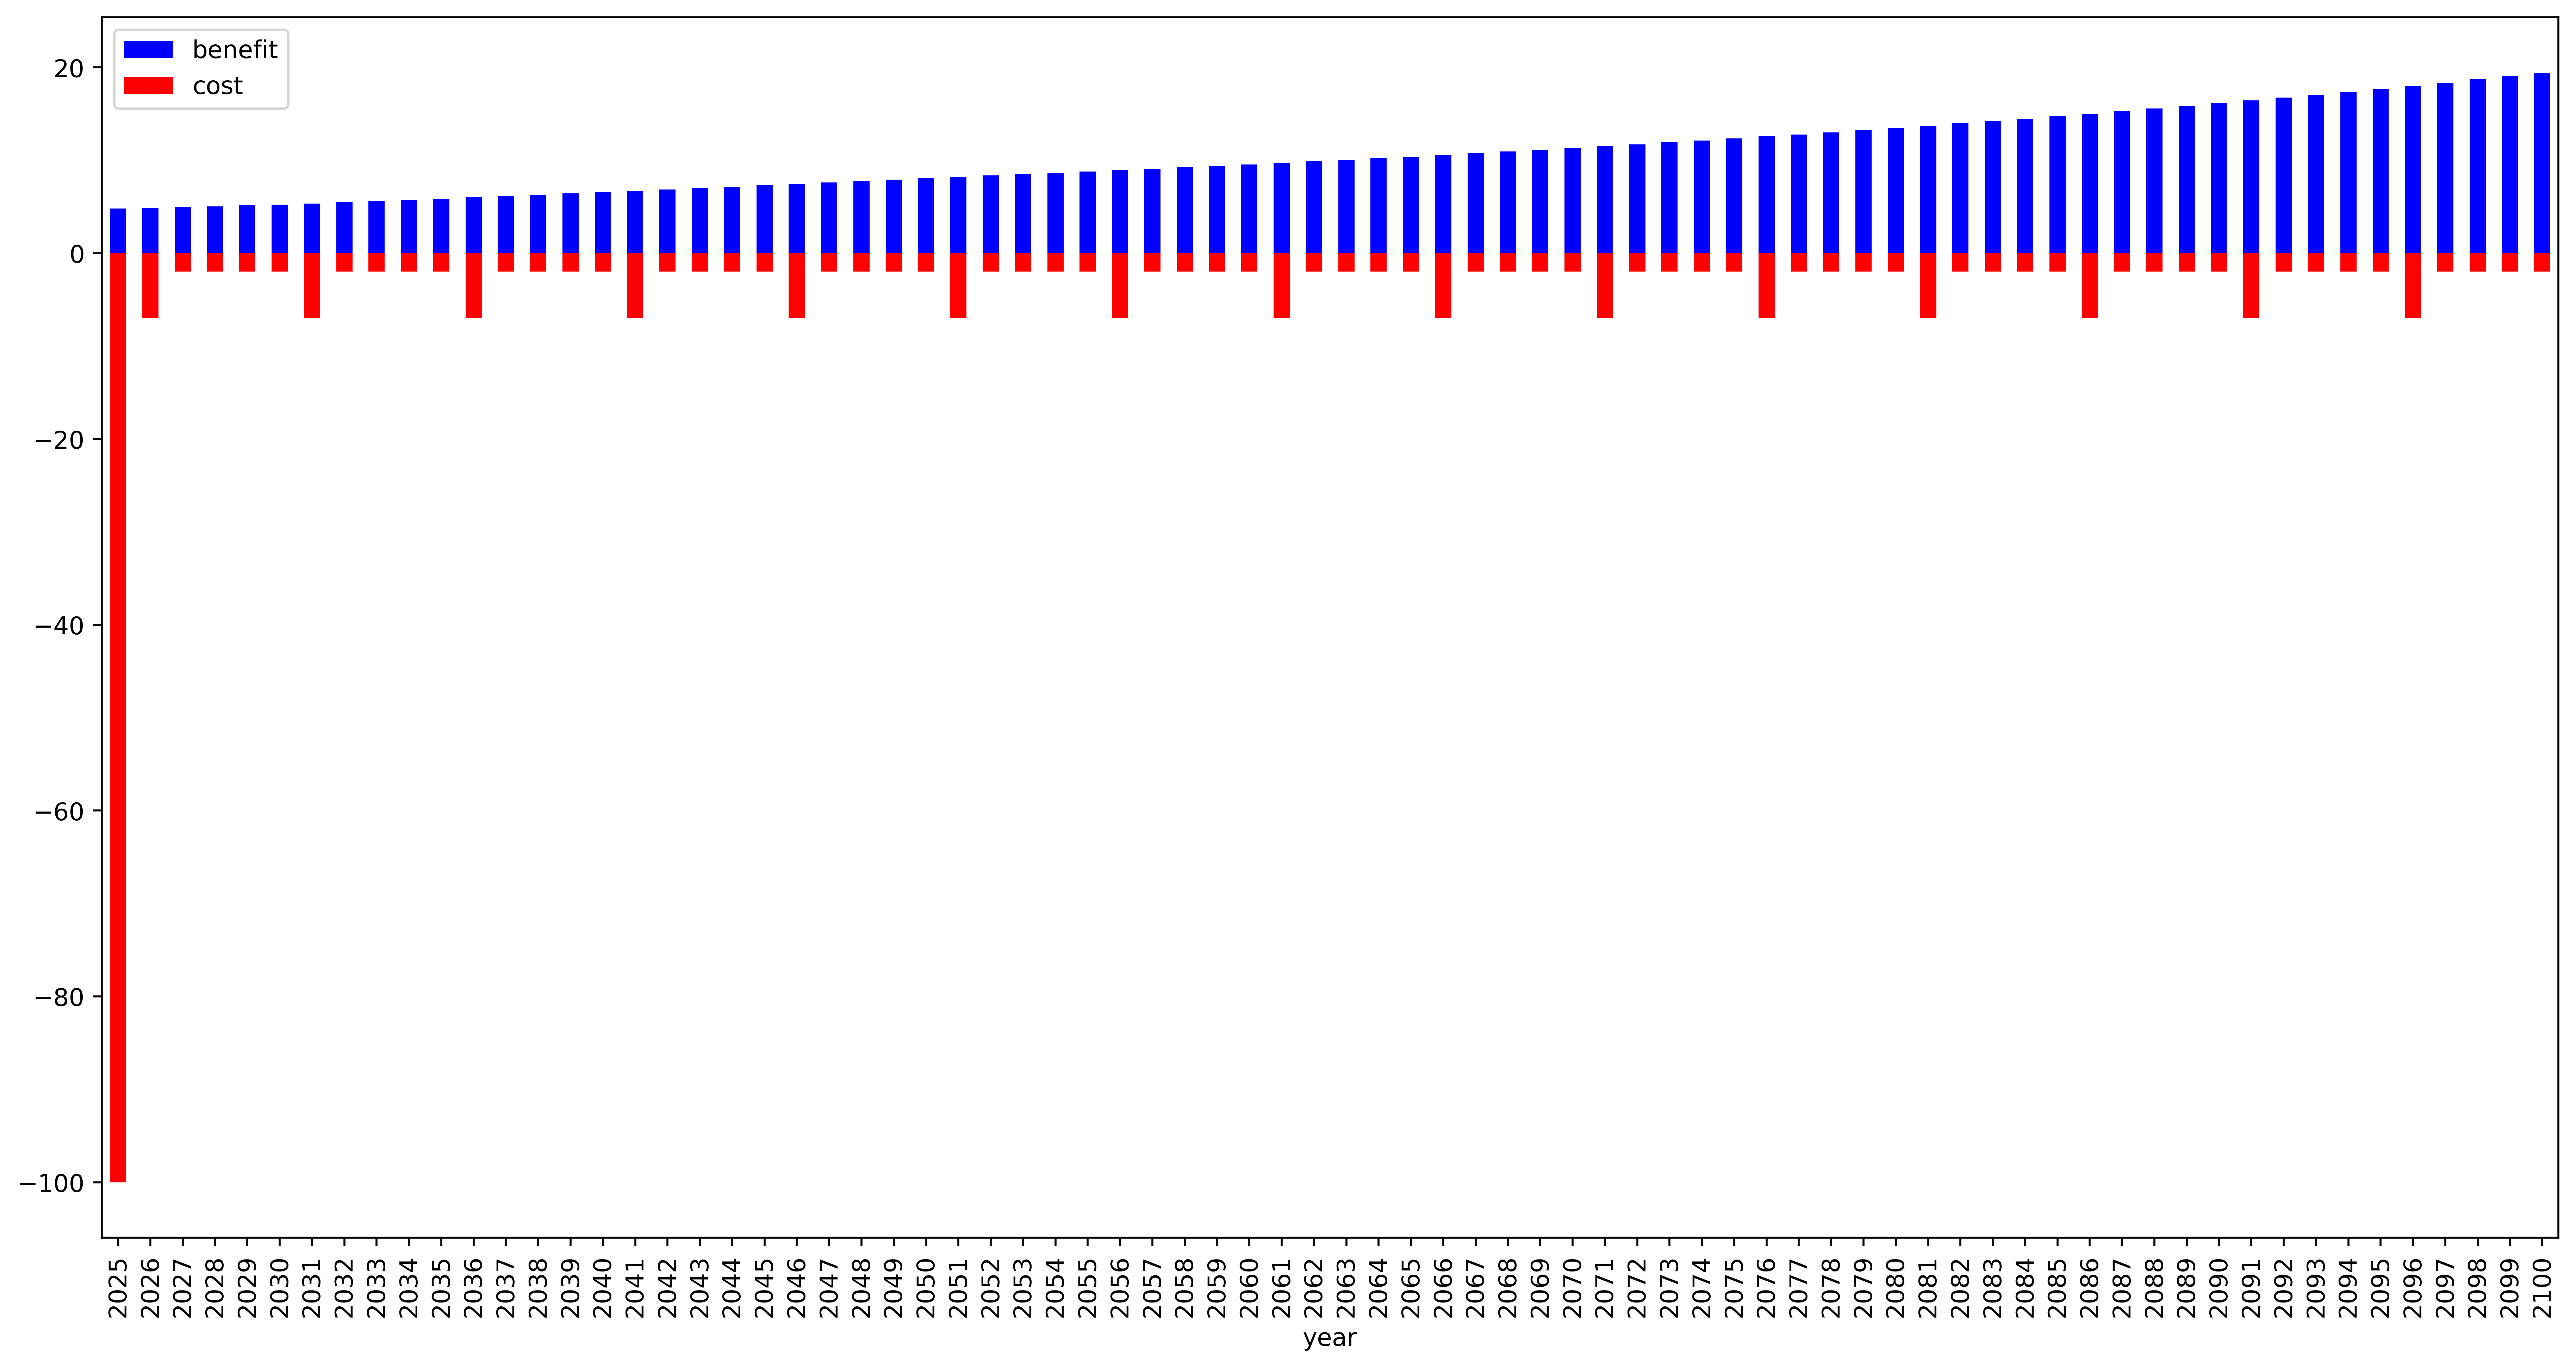

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(18, 9), dpi=500)
test_df = adapt_df[(adapt_df["id"] == 2) & (adapt_df["option"] == "swales")]
test_df["cost"] = -1.0 * test_df["cost"]
test_df.plot.bar(ax=ax, x=year_column, y="benefit", color="b")
test_df.plot.bar(ax=ax, x=year_column, y="cost", color="r")

<Axes: xlabel='year'>

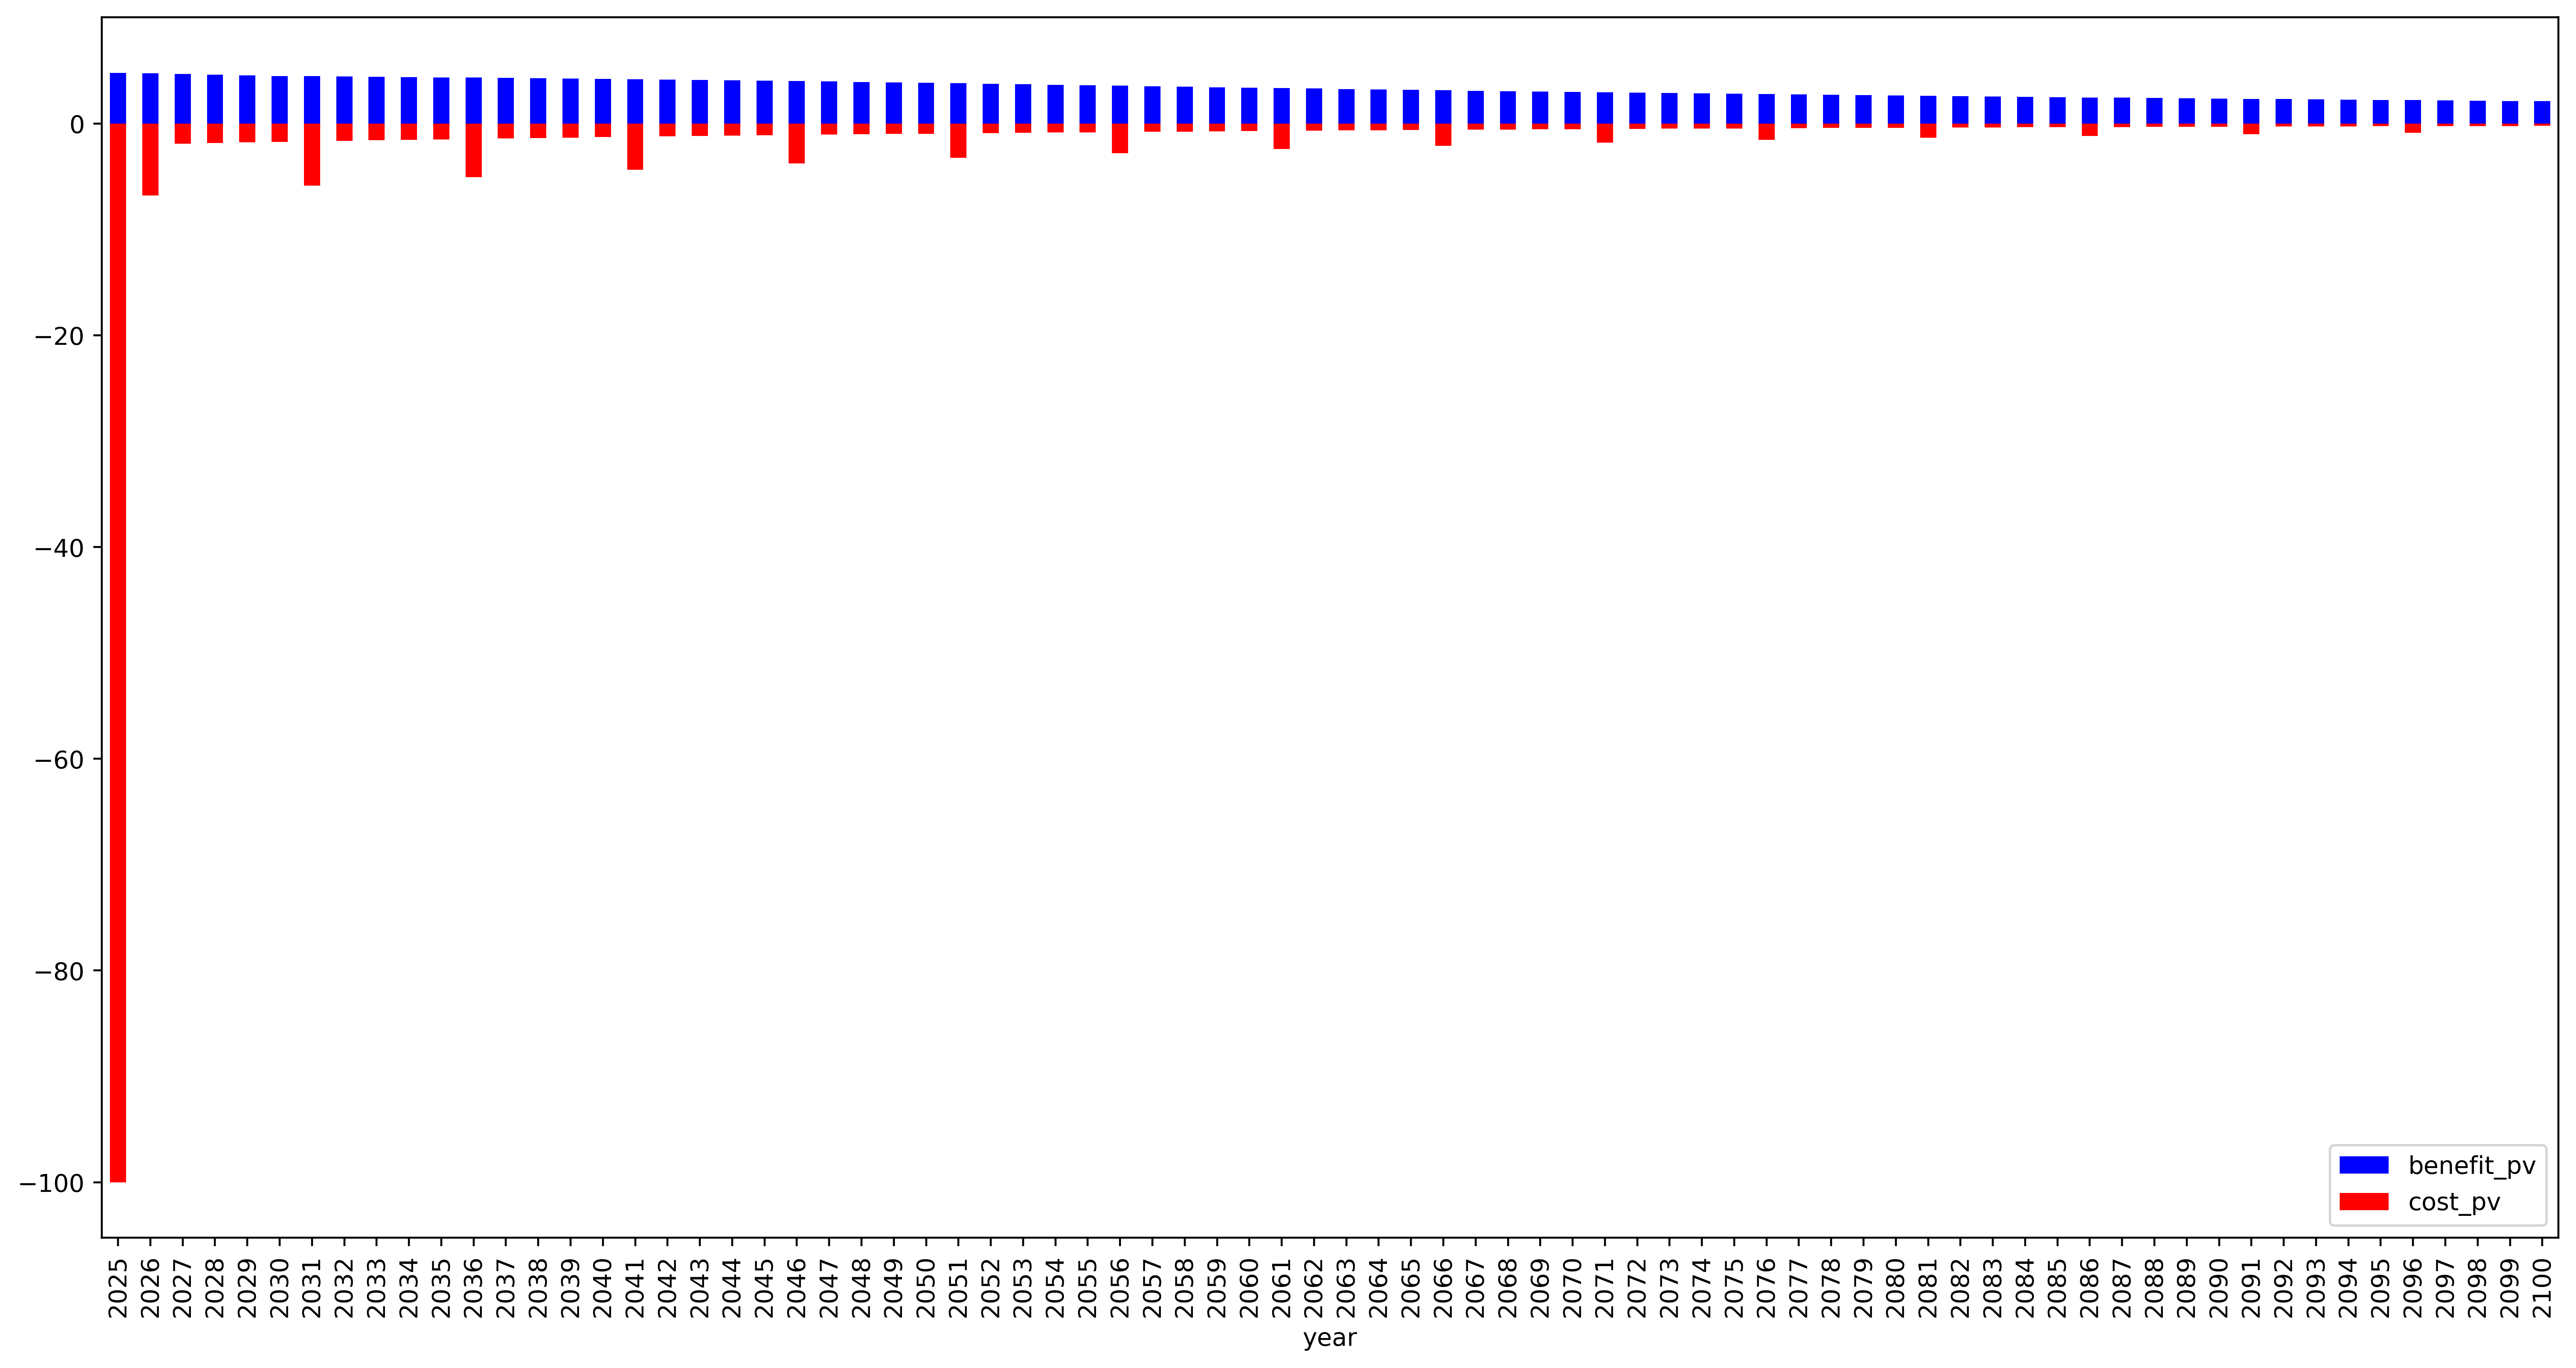

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(18, 9), dpi=500)
test_df = adapt_df[(adapt_df["id"] == 2) & (adapt_df["option"] == "swales")]
test_df["cost_pv"] = -1.0 * test_df["cost_pv"]
test_df.plot.bar(ax=ax, x=year_column, y="benefit_pv", color="b")
test_df.plot.bar(ax=ax, x=year_column, y="cost_pv", color="r")